# Engineering Calculations Essentials Notebook

This notebook keeps the examples lightweight and focused on core Python skills for engineering workflows.

## 0. Setup

Import the small collection of tools we'll use for quick calculations and charts.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## 1. Quick Unit Conversions

Define a couple of helpers to convert between common units without pulling in a full library.

In [12]:
UNIT_FACTORS = {
    ("kN", "N"): 1_000,
    ("N", "kN"): 1 / 1_000,
    ("m", "mm"): 1_000,
    ("mm", "m"): 1 / 1_000,
    ("MPa", "Pa"): 1_000_000,
    ("Pa", "MPa"): 1 / 1_000_000,
    ("mm2", "m2"): 1 / 1_000_000,
    ("m2", "mm2"): 1_000_000,
}


def convert(value, from_unit, to_unit):
    """Convert between a small set of predefined unit pairs."""
    key = (from_unit, to_unit)
    if key not in UNIT_FACTORS:
        raise ValueError(f"Conversion from {from_unit} to {to_unit} not defined")
    return value * UNIT_FACTORS[key]


example_lengths_m = [2.5, 3.0, 4.75]
converted_mm = [convert(length, "m", "mm") for length in example_lengths_m]
for original, converted in zip(example_lengths_m, converted_mm):
    print(f"{original:.2f} m -> {converted:.0f} mm")

2.50 m -> 2500 mm
3.00 m -> 3000 mm
4.75 m -> 4750 mm


## 2. Load Summary Table

Represent a small set of loads and summarise them with pandas. The factors here are illustrative only.

In [13]:
load_cases = [
    {"name": "Dead", "magnitude_kN": 8.0, "factor": 1.2},
    {"name": "Live", "magnitude_kN": 5.5, "factor": 1.6},
    {"name": "Roof", "magnitude_kN": 2.1, "factor": 1.0},
]


df_loads = pd.DataFrame(load_cases)
df_loads["factored_kN"] = df_loads["magnitude_kN"] * df_loads["factor"]
display(df_loads)
print("Total service load (kN):", df_loads["magnitude_kN"].sum())
print("Total factored load (kN):", df_loads["factored_kN"].sum())

,name,magnitude_kN,factor,factored_kN
0,Dead,8.0,1.2,9.6
1,Live,5.5,1.6,8.8
2,Roof,2.1,1.0,2.1


Total service load (kN): 15.6
Total factored load (kN): 20.5


## 3. Axial Stress Check

Use a tiny helper to compute axial stress and compare it with a simple allowable value.

In [14]:
def axial_stress(force_kN, area_mm2):
    force_N = convert(force_kN, "kN", "N")
    area_m2 = convert(area_mm2, "mm2", "m2")
    return force_N / area_m2  # Pa


allowable_stress_MPa = 180
trial_members = [
    {"label": "Column A", "force_kN": 650, "area_mm2": 32_000},
    {"label": "Column B", "force_kN": 540, "area_mm2": 25_000},
    {"label": "Column C", "force_kN": 420, "area_mm2": 20_000},
]


for member in trial_members:
    stress_Pa = axial_stress(member["force_kN"], member["area_mm2"])
    stress_MPa = convert(stress_Pa, "Pa", "MPa")
    ratio = stress_MPa / allowable_stress_MPa
    print(f"{member['label']}: {stress_MPa:.1f} MPa ({ratio:.2%} of allowable)")

Column A: 20.3 MPa (11.28% of allowable)
Column B: 21.6 MPa (12.00% of allowable)
Column C: 21.0 MPa (11.67% of allowable)


## 4. Beam Deflection Analysis

Calculate deflection for a simply supported beam with uniform load using the equation:

δ_max = (5wL⁴)/(384EI)

We'll vary the span and plot deflection against the L/360 serviceability limit.

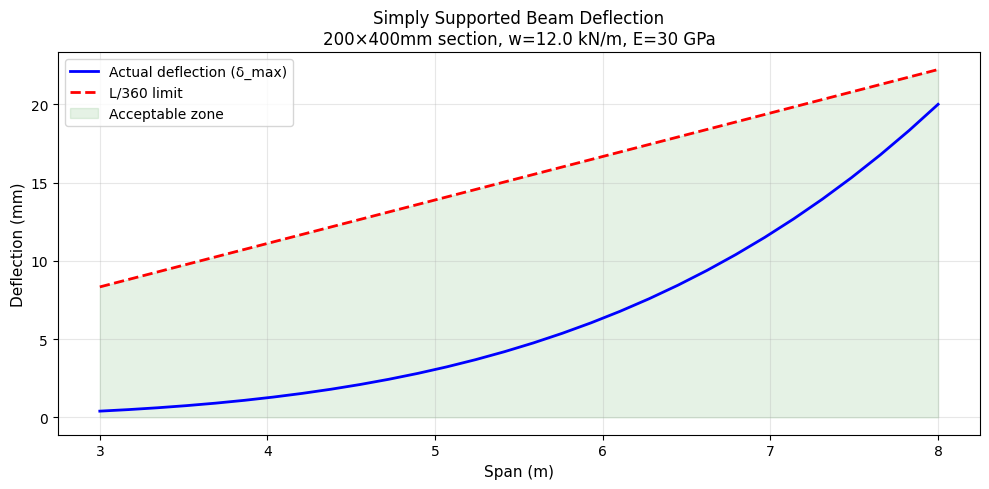


Critical span (deflection ≈ L/360): 8.00 m


In [16]:
# Beam properties
uniform_load_kN_m = 12.0  # Uniform distributed load
width_mm = 200
depth_mm = 400
E_concrete_GPa = 30  # Elastic modulus for concrete

# Calculate section properties
width_m = width_mm / 1000
depth_m = depth_mm / 1000
I_m4 = (width_m * depth_m**3) / 12  # Moment of inertia for rectangular section
E_Pa = E_concrete_GPa * 1e9

# Convert load to N/m
w_N_m = uniform_load_kN_m * 1000

# Calculate deflection for range of spans
span_m = np.linspace(3.0, 8.0, 30)
# δ_max = (5wL⁴)/(384EI)
deflection_m = (5 * w_N_m * span_m**4) / (384 * E_Pa * I_m4)
deflection_mm = deflection_m * 1000

# L/360 serviceability limit
limit_mm = (span_m * 1000) / 360

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(span_m, deflection_mm, 'b-', linewidth=2, label="Actual deflection (δ_max)")
ax.plot(span_m, limit_mm, 'r--', linewidth=2, label="L/360 limit")
ax.fill_between(span_m, 0, limit_mm, alpha=0.1, color='green', label='Acceptable zone')
ax.set_xlabel("Span (m)", fontsize=11)
ax.set_ylabel("Deflection (mm)", fontsize=11)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_title(f"Simply Supported Beam Deflection\n{width_mm}×{depth_mm}mm section, w={uniform_load_kN_m} kN/m, E={E_concrete_GPa} GPa", fontsize=12)
plt.tight_layout()
plt.show()

# Print critical span where deflection equals limit
critical_idx = np.argmin(np.abs(deflection_mm - limit_mm))
critical_span = span_m[critical_idx]
print(f"\nCritical span (deflection ≈ L/360): {critical_span:.2f} m")